## Introduction

Welcome to our spam message detection project! Here, we'll leverage machine learning to differentiate between legitimate messages and spam. We'll employ AI to explore prediction using different machine learning models. Let's begin this practical exploration!

Here are the steps that we are going to follow for text cleaning data:

* LowerCase
* Tokenize
* Remove punctuation
* Remove stopwords
* Lemmatizing

After We are going to Vectorize our data into a set of numbers to make it possible for the Machine Learning Models to learn from it because ML models only proccess numerical features :

* Vectorizing (TfidfVectorizer)

## Imports

In [2]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


import nltk

import string
from nltk.tokenize import word_tokenize
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import TfidfVectorizer


from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import lightgbm as ltb
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score 

## Getting Data

In [3]:
data = pd.read_csv("spamham.csv")
data.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  5572 non-null   object
 1   Message   5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


We have a simple dataset with 5572 observations with **no Missing Values** .We also got one feature **(Message)** and one target **(Category)**

<Axes: xlabel='Category', ylabel='count'>

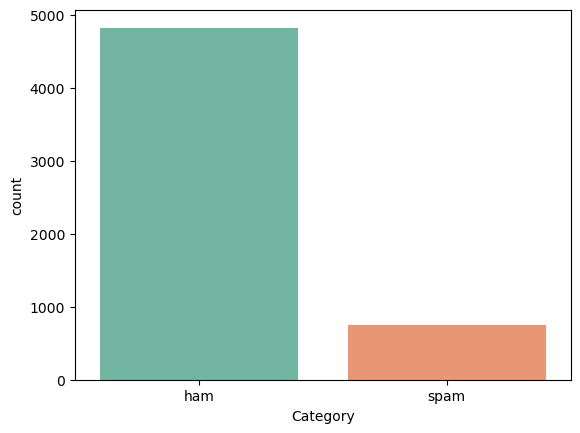

In [5]:
sns.countplot(x="Category",data=data, palette="Set2")

We can clearly see that most of our messages are ham , it's true that this means our dataset is inbalanced but it makes sens because most of the messages in general are **ham messages** However, we are going later to balance this dataset

## Data Cleaning and Preprocessing

Text data preprocessing stands as a vital preliminary phase in natural language processing (NLP). Its essence lies in eliminating disturbances, irregularities, and extraneous content from the text, thereby enhancing data integrity for subsequent analysis. Our approach aligns with the outlined steps in the Introduction.

### Removing Punctuation and Stopwords

In [6]:
def cleaning (text):
    text = text.lower()
    text =  re.sub(r'@\S+', '',text)
    text =  re.sub(r'http\S+', '',text) # remove urls
    text =  re.sub(r'pic.\S+', '',text)
    text =  re.sub(r"[^a-zA-ZáéíóúÁÉÍÓÚ']", ' ',text) # only keeps characters
    text =  re.sub(r'\s+[a-zA-ZáéíóúÁÉÍÓÚ]\s+', ' ', text+' ')  # keep words with length>1 only
    text = "".join([i for i in text if i not in string.punctuation])
    words = word_tokenize(text)
    stopwords = nltk.corpus.stopwords.words('english')   # remove stopwords
    text = " ".join([i for i in words if i not in stopwords])
    text= re.sub("\s[\s]+", " ",text).strip()
    text= re.sub("\s[\s]+", " ",text).strip() # remove repeated/leading/trailing spaces
    return text

In [7]:
data["Message"]=data["Message"].apply(cleaning)

### Lemmatization

Lemmatization serves as a text preprocessing method within the realm of natural language processing (NLP) models. Its purpose is to deconstruct words to their fundamental root, facilitating the recognition of resemblances and similarities.

In [8]:
def lemm(data):
    wordnet = WordNetLemmatizer()
    lemmanized = []
    for i in range(len(data)):
        lemmed = []
        words = word_tokenize(data['Message'].iloc[i])
        for w in words:
            lemmed.append(wordnet.lemmatize(w))
        lemmanized.append(lemmed)

    data['lemmanized'] = lemmanized
    data['text'] = data['lemmanized'].apply(' '.join)
    data=data.drop("lemmanized",axis=1)
    data=data.drop("Message",axis=1)
    return data

In [9]:
data = lemm(data)

### Encoding

Sure we are not going to leave the target **Category** as an object type because we can't feed it into machine learning models for that we will use a map to encode it's values

In [10]:
mesg = {"ham":0,"spam":1}
data["Category"]=data["Category"].map(mesg)

## Spliting Data

### OverSampling

We are going to balance our dataset with a simple methode : we are going to create some samples for the smaller class to make it the same size as the ham class . This methode is called **Oversampling** 

In [11]:
clas0,clas1=data["Category"].value_counts()
df0=data[data["Category"]==0]
df1=data[data["Category"]==1]
df1=df1.sample(clas0,replace=True)
data = pd.concat([df0,df1])

In [12]:
labels = data["Category"]
data = data["text"]
labels.value_counts()

0    4825
1    4825
Name: Category, dtype: int64

We should now split our data now into training and test sets so we can fit and evaluate our model properly

In [13]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2)

## Feature Extraction

### TF-ID Vectoriser

Vectorization with TF-IDF (Term Frequency-Inverse Document Frequency) is a method in NLP that converts text into numerical form and it tends to have a good performance in spam detection because it takes into account the importance of words based on their frequency in the document and their rarity across the entire corpus. This can help in distinguishing relevant words from common ones that might not contribute much to the task, potentially leading to better separation between legitimate messages and spam.

In [14]:
tfid = TfidfVectorizer()
X_train = tfid.fit_transform(X_train)
X_test = tfid.transform(X_test)

## Training models

### LogisticRegression

In [15]:
lr = LogisticRegression()
lr.fit(X_train,y_train)
preds = lr.predict(X_test)
print(accuracy_score(preds,y_test))

0.9854922279792746


### Decision Tree

In [16]:
tree = DecisionTreeClassifier()
tree.fit(X_train,y_train)
preds = tree.predict(X_test)
print(accuracy_score(preds,y_test))

0.9766839378238342


### Random Forest

In [17]:
forest = RandomForestClassifier()
forest.fit(X_train,y_train)
preds = forest.predict(X_test)
print(accuracy_score(preds,y_test))

0.9963730569948187


### LightGBM

In [18]:
clf = ltb.LGBMClassifier()
clf.fit(X_train, y_train)
preds = clf.predict(X_test)
print(accuracy_score(preds,y_test))

[LightGBM] [Info] Number of positive: 3821, number of negative: 3899
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024480 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12006
[LightGBM] [Info] Number of data points in the train set: 7720, number of used features: 767
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.494948 -> initscore=-0.020208
[LightGBM] [Info] Start training from score -0.020208
0.9906735751295337


### Naive Bayes

Notice that we are going to convert X_train and X_test to arrays because Naive Bayes don't support sparse data created by the TFidVectoriser

In [19]:
naive = GaussianNB()
naive.fit(X_train.toarray(), y_train)
preds = naive.predict(X_test.toarray())
print(accuracy_score(preds,y_test))

0.9341968911917099


### Support Vector Machine

In [20]:
SVM = SVC()
SVM.fit(X_train, y_train)
preds = SVM.predict(X_test)
print(accuracy_score(preds,y_test))

0.9968911917098445
